In [46]:
import os, operator, itertools, pickle, sys
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, confusion_matrix
import statsmodels.formula.api as sm

from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression

from scipy.stats import boxcox
from scipy.special import inv_boxcox

import nltk, string, os
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

np.random.seed(0)

In [47]:
sys.path.insert(0, '../objects')
sys.path.insert(0, '../data')
sys.path.insert(0, '../pickles')

In [48]:
from Axe_Object import Axe

In [49]:
file_names = [name for name in os.listdir('../data/axe_specs/') if not name.startswith('.')] # Ignores hidden files on mac

In [50]:
axes = []
for filename in file_names:
    try:
        this_axe = Axe('../data/axe_listings', '../data/axe_specs', filename)
        if "LOT OF" not in this_axe.title.upper() and this_axe.price > 110 and this_axe.price < 890:
            if this_axe.string_config and this_axe.string_config < 5:
                continue
            if this_axe.market != 'EBAY-US':
                continue
            if this_axe.year and this_axe.year > 2019:
                continue
            axes.append(this_axe)
    except ValueError:
        pass

In [51]:
len(axes)

11026

In [52]:
orig_prices = pd.Series([axe.price for axe in axes], name = 'prices')

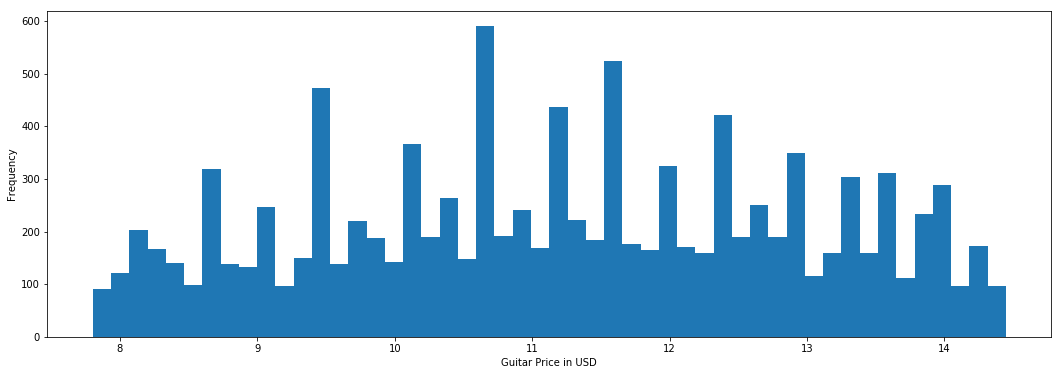

In [55]:
bxcx_lam = .2
prices = pd.Series(boxcox([axe.price for axe in axes], lmbda=bxcx_lam), name = 'prices')
plt.figure(figsize = (18,6))
plt.hist(prices, bins=50)
plt.ylabel('Frequency')
plt.xlabel('Guitar Price in USD')
plt.show()

In [56]:
auction_duration    = pd.Series([axe.duration for axe in axes], name = 'auction_duration')
shipping_charged    = pd.Series([axe.price_shipping for axe in axes], name = 'shipping_charged')
seller_country      = pd.Series([axe.country_seller for axe in axes], name = 'seller_country')
autopay             = pd.Series([axe.autopay for axe in axes], name = 'autopay')
returns             = pd.Series([axe.returns for axe in axes], name = 'returns')
listing_type        = pd.Series([axe.listing_type for axe in axes], name = 'listing_type')
ship_type           = pd.Series([axe.ship_type for axe in axes], name = 'ship_type')
ship_expedite       = pd.Series([axe.ship_expedite for axe in axes], name = 'ship_expedite')
start_hour          = pd.cut(pd.Series([axe.start_time.hour for axe in axes], name = 'start_hour'), 6)
end_hour            = pd.cut(pd.Series([axe.end_time.hour for axe in axes], name = 'end_hour'), 6)
start_weekday       = pd.Series([axe.start_weekday for axe in axes], name = 'start_weekday').astype('category')
end_weekday         = pd.Series([axe.end_weekday for axe in axes], name = 'end_weekday').astype('category')
returns_time        = pd.Series([axe.returns_time for axe in axes], name = "returns_time").astype('category')
num_pics            = pd.Series([axe.pic_quantity for axe in axes], name = "num_pics")
brand               = pd.Series([axe.brand for axe in axes], name = "brand")
body_type           = pd.Series([axe.body_type for axe in axes], name = "body_type")
color               = pd.Series([axe.color for axe in axes], name = "color")
right_left_handed   = pd.Series([axe.right_left_handed for axe in axes], name = "right_left_handed")
best_offer_enabled  = pd.Series([axe.best_offer_enabled for axe in axes], name = "best_offer_enabled")
country_manufacture = pd.Series([axe.country_manufacture for axe in axes], name = "country_manufacture")

ship_handling_time = pd.Series([axe.ship_handling_time for axe in axes], name = 'ship_handling_time').astype('category')

string_config = pd.cut(pd.Series([axe.string_config for axe in axes], name = "string_config"),
                       [0,5,6,11,20])

seller_feedback_score = pd.cut(pd.Series([axe.seller_feedback_score for axe in axes], name = "seller_feedback_score"), [-411,0,50,100,200,500,750,1250,2500,10000,100000,400000])

seller_positive_percent = pd.cut(pd.Series([axe.seller_positive_percent for axe in axes], name = "seller_positive_percent"), [-10000,99.5,111])

model_year = pd.cut(pd.Series([axe.year for axe in axes], name = "model_year"), [1700,1975,1990,1995,2000,2005,2007,2010,2011,2012,2013,2015])

## Text as a Regression Feature

http://www-stat.wharton.upenn.edu/~stine/research/regressor.pdf

In [57]:
def assemble_guitar_document(axe):
    document = axe.title + ' '
    if axe.year != None:
        document += (str(axe.year) + ' ')
    if axe.material != None:
        document += axe.material + ' '
    if axe.model != None:
        document += axe.model + ' ' 
    if axe.brand != None:
        document += axe.brand + ' '
    if axe.subtitle != None:
        document += axe.subtitle + ' '
    if axe.condition_description != None:
        document += axe.condition_description + ' '
    if axe.description != None:
        document += axe.description
    return document

In [58]:
raw_corpus = [assemble_guitar_document(axe).lower() for axe in axes]

In [59]:
stemmer = SnowballStemmer("english")

In [60]:
stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``', ",", ".", ":", "'s", "--","’"]

In [61]:
def process_doc(doc):
    stopwords_removed = ''
    tokens = nltk.word_tokenize(doc)
    for i in range(len(tokens)):
        if tokens[i].lower() not in stopwords_list and tokens[i] not in string.punctuation:
            stopwords_removed += stemmer.stem(tokens[i]) + ' '
    return stopwords_removed

In [62]:
processed_text = pd.Series(list(map(process_doc, raw_corpus)), name = 'text')

## Assemble the Feature Set

In [63]:
y_X_dummies = pd.concat([prices, brand, color, country_manufacture, right_left_handed, best_offer_enabled, shipping_charged, 
               returns, returns_time, autopay, seller_country, ship_handling_time, listing_type, ship_expedite,
               ship_type, num_pics, auction_duration, start_hour, end_hour, start_weekday, end_weekday, 
               seller_positive_percent, model_year, body_type, string_config],
              axis = 1)

y_X = pd.get_dummies(y_X_dummies, drop_first=True)

In [64]:
filename = '../pickles/bonus_columns'
outfile = open(filename, 'wb')
pickle.dump(list(y_X.iloc[:,1:].columns), outfile)
outfile.close()

### SPLIT

In [65]:
y_X = pd.concat([y_X, processed_text], axis=1)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(y_X.iloc[:,1:], y_X.iloc[:,0], test_size=.15)#, random_state=42)

In [67]:
X_train.shape

(9372, 121)

### Scale It 

In [68]:
scaler = StandardScaler()

In [69]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.iloc[:,:-1]), columns=X_train.iloc[:,:-1].columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test.iloc[:,:-1]), columns=X_test.iloc[:,:-1].columns)

/anaconda3/envs/Bayes/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/Bayes/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/envs/Bayes/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [70]:
outfile = open('../pickles/saved_scaler','wb')
pickle.dump(scaler,outfile)
outfile.close()

In [71]:
X_test_scaled.shape

(1654, 120)

Text Features vectorization

In [72]:
vectorizer = TfidfVectorizer(norm=None, ngram_range=(2,3), strip_accents='ascii',
#                             max_df=0.8, min_df=2,
                             max_features=300)

vectorizer.fit(X_train['text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=300, min_df=1,
        ngram_range=(2, 3), norm=None, preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents='ascii', sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [73]:
outfile = open('../pickles/saved_vectorizer','wb')
pickle.dump(vectorizer,outfile)
outfile.close()

In [74]:
tfidf_train = vectorizer.transform(X_train['text'])
tfidf_train_df = pd.DataFrame(tfidf_train.toarray(), columns=vectorizer.get_feature_names())

tfidf_test = vectorizer.transform(X_test['text'])
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=vectorizer.get_feature_names())

X_train_ready = pd.concat([X_train.reset_index(drop=True), tfidf_train_df], axis=1).drop('text',axis=1)
X_test_ready = pd.concat([X_test.reset_index(drop=True), tfidf_test_df], axis=1).drop('text',axis=1)

In [115]:
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

In [129]:
board_data = pd.DataFrame(vectorizer.transform(processed_text).toarray(), columns = vectorizer.get_feature_names())
board_data.shape

(11026, 300)

In [138]:
LOG_DIR = 'logs'
board_data_tf = tf.Variable(board_data, name='board_data_tf')

In [139]:
metadata = os.path.join(LOG_DIR, 'metadata.tsv')

In [140]:
with open(metadata, 'w') as metadata_file:
    for row in [axe.title[:25] for axe in axes]:
        metadata_file.write('%s\n' % row)

In [141]:
with tf.Session() as sess:
    saver = tf.train.Saver([board_data_tf])

    sess.run(board_data_tf.initializer)
    saver.save(sess, os.path.join(LOG_DIR, 'board_data_tf.ckpt'))

    config = projector.ProjectorConfig()
    # One can add multiple embeddings.
    embedding = config.embeddings.add()
    embedding.tensor_name = board_data_tf.name
    # Link this tensor to its metadata file (e.g. labels).
    embedding.metadata_path = metadata
    # Saves a config file that TensorBoard will read during startup.
    projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)

### Baseline Naive Error - Guess the Mean Price

In [37]:
price_mean = np.mean(y_train)
price_mean_vector = inv_boxcox([price_mean for i in range(len(y_test))],bxcx_lam)
baseline_error = np.sqrt(mean_squared_error(inv_boxcox(y_test, bxcx_lam), price_mean_vector))
baseline_error

207.93275354033062

In [38]:
X_train_ready.head()

,best_offer_enabled,shipping_charged,returns,autopay,ship_expedite,num_pics,auction_duration,brand_CHARVEL,brand_DEAN,brand_EPIPHONE,brand_ESP,brand_FENDER,brand_G&L,brand_GIBSON,brand_GRETSCH,brand_IBANEZ,brand_JACKSON,brand_OTHER,brand_PEAVEY,brand_PRS,brand_RICKENBACKER,brand_SCHECTER,brand_SQUIER,brand_WASHBURN,brand_YAMAHA,color_BLUE,color_GREEN,color_NATURAL,color_OTHER,color_RED,color_SUNBURST,color_WHITE,color_YELLOW,country_manufacture_CHINA,country_manufacture_COLOMBIA,country_manufacture_FRANCE,country_manufacture_GEORGIA,country_manufacture_GERMANY,country_manufacture_INDIA,country_manufacture_INDONESIA,country_manufacture_ISRAEL,country_manufacture_ITALY,country_manufacture_JAPAN,country_manufacture_KOREA,country_manufacture_MEXICO,country_manufacture_N/A,country_manufacture_PUERTO RICO,country_manufacture_RUSSIAN FEDERATION,country_manufacture_SAINT HELENA,country_manufacture_SWEDEN,country_manufacture_SWITZERLAND,country_manufacture_TAIWAN,country_manufacture_UKRAINE,country_manufacture_UNITED KINGDOM,country_manufacture_UNKNOWN,country_manufacture_USA,country_manufacture_VIETNAM,right_left_handed_RIGHT,returns_time_14,returns_time_30,returns_time_60,seller_country_GB,seller_country_JP,seller_country_OTHER,seller_country_US,ship_handling_time_1,ship_handling_time_2,ship_handling_time_3,ship_handling_time_4,ship_handling_time_5,ship_handling_time_10,ship_handling_time_15,listing_type_FixedPrice,listing_type_StoreInventory,ship_type_CalculatedDomesticFlatInternational,ship_type_Flat,ship_type_FlatDomesticCalculatedInternational,ship_type_Free,ship_type_FreePickup,ship_type_Freight,"start_hour_(3.833, 7.667]","start_hour_(7.667, 11.5]","start_hour_(11.5, 15.333]","start_hour_(15.333, 19.167]","start_hour_(19.167, 23.0]","end_hour_(3.833, 7.667]","end_hour_(7.667, 11.5]","end_hour_(11.5, 15.333]","end_hour_(15.333, 19.167]","end_hour_(19.167, 23.0]",start_weekday_1,start_weekday_2,start_weekday_3,start_weekday_4,start_weekday_5,start_weekday_6,end_weekday_1,end_weekday_2,end_weekday_3,end_weekday_4,end_weekday_5,end_weekday_6,"seller_positive_percent_(99.5, 111.0]","model_year_(1975, 1990]","model_year_(1990, 1995]","model_year_(1995, 2000]","model_year_(2000, 2005]","model_year_(2005, 2007]","model_year_(2007, 2010]","model_year_(2010, 2011]","model_year_(2011, 2012]","model_year_(2012, 2013]","model_year_(2013, 2015]",body_type_HOLLOW,body_type_OTHER,body_type_SEMI-HOLLOW,body_type_SOLID,"string_config_(5, 6]","string_config_(6, 11]","string_config_(11, 20]",14 day,30 day,48 state,accept paypal,actual item,ad follow,addit cost,addit cost prior,addit ship,amp amp,amp amp amp,amp amp gt,amp amp lt,amp gt,amp gt amp,amp lt,ask question,auction end,back neck,bidding buy,bodi electr,bodi electr guitar,bodi neck,bolt on,brand new,bridg pickup,busi day,busi day payment,buyer pay,buyer pleas,buyer respons,buyer respons pleas,case includ,charg buyer,charg buyer respons,charg charg,charg charg buyer,charg includ,charg includ item,check countri,check countri custom,coil pickup,combin ship,come origin,condit guitar,condit use,contact us,cost prior,cost prior bidding,cost ship,countri custom,countri custom offic,custom offic,custom offic determin,custom shop,day auction,day payment,day receipt,day return,describ item,determin addit,determin addit cost,duti tax,duti tax charg,ebay ship,electr guitar,electr guitar black,electron work,end auction,epiphon les,epiphon les paul,esp ltd,estim ship,excel condit,feel free,feel free ask,feel free contact,fender american,fender fender,fender squier,fender stratocast,fender telecast,flame mapl,floyd rose,free ask,free ask question,free contact,free ship,fret wear,full refund,gibson les,gibson les paul,gibson sg,gig bag,good condit,good luck,good shape,great condit,great guitar,great shape,great sound,gt amp,guitar black,guitar case,guitar come,guitar excel,guitar excel condit,guitar good,guitar great,guitar hard,guitar look,guitar made,guitar play,guitar ship,guitar use,hard case,hard she

### Lasso Regression

In [39]:
lin_reg = LassoCV(cv=3).fit(X_train_ready, y_train)

/anaconda3/envs/Bayes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/Bayes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/Bayes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/Bayes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not conver

/anaconda3/envs/Bayes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/Bayes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/Bayes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/Bayes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not conver

/anaconda3/envs/Bayes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/Bayes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/Bayes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/Bayes/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not conver

In [40]:
outfile = open('../pickles/lasso_model','wb')
pickle.dump(lin_reg,outfile)
outfile.close()

In [41]:
y_train_preds = lin_reg.predict(X_train_ready)
y_test_preds = lin_reg.predict(X_test_ready)

In [42]:
y_train_inv = inv_boxcox(y_train, bxcx_lam)
y_test_inv = inv_boxcox(y_test, bxcx_lam)
y_train_preds_inv = inv_boxcox(y_train_preds, bxcx_lam)
y_test_preds_inv = inv_boxcox(y_test_preds, bxcx_lam)

In [43]:
train_error = np.sqrt(mean_squared_error(y_train_inv, y_train_preds_inv))
test_error = np.sqrt(mean_squared_error(y_test_inv, y_test_preds_inv))
(train_error, test_error)

(162.85033072811393, 171.09066052690767)

In [44]:
print(f'Train error is a {round((((baseline_error - train_error) / baseline_error) * 100),2)}% improvement over guessing the mean. \n')

print(f'Test error is a {round((((baseline_error - test_error) / baseline_error) * 100),2)}% improvement over guessing the mean.')

Train error is a 21.68% improvement over guessing the mean. 

Test error is a 17.72% improvement over guessing the mean.


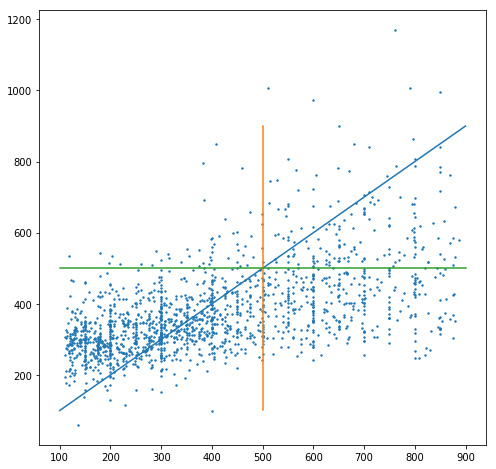

In [45]:
plt.figure(figsize=(8,8))
plt.scatter(y_test_inv, y_test_preds_inv, s=2)
x = np.linspace(100,900, num=2)
plt.plot(x,x)
plt.plot(np.full(len(x),500),x)
plt.plot(x,np.full(len(x),500))
plt.show()

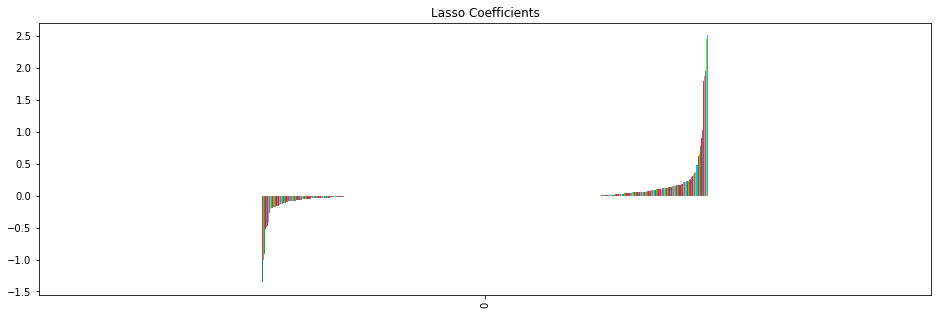

In [46]:
coef = pd.DataFrame(data = lin_reg.coef_, index=X_train_ready.columns)
model_coef = coef.sort_values(by=0).T
model_coef.plot(kind='bar', title='Lasso Coefficients', legend=False, figsize=(16,5))
plt.show()

In [47]:
t_mod = model_coef.T
lasso_feats = t_mod[abs(t_mod) > 0].dropna()
lasso_feats

,0
brand_SQUIER,-1.354883e+00
ship_type_Flat,-1.003478e+00
country_manufacture_CHINA,-9.171173e-01
country_manufacture_INDONESIA,-5.167821e-01
ship_expedite,-4.965924e-01
fender squier,-4.736567e-01
brand_PEAVEY,-4.302675e-01
electr guitar,-2.752582e-01
brand_EPIPHONE,-2.023109e-01
new string,-1.970747e-01


Can I get a confusion matrix?

In [48]:
price_thresh = 510

In [49]:
high_actual = y_test_inv > price_thresh

In [50]:
bad_guesses = np.full(len(y_test_inv), True)
bad_cnf_matrix = confusion_matrix(high_actual, bad_guesses)
print(f'If you just guessed every guitar would sell for more than ${price_thresh} you\'d only be right {round((bad_cnf_matrix[1][1] / (bad_cnf_matrix[1][1] + bad_cnf_matrix[0][1]))*100, 2)}% of the time.')

If you just guessed every guitar would sell for more than $510 you'd only be right 29.13% of the time.


In [51]:
high_preds = y_test_preds_inv > price_thresh

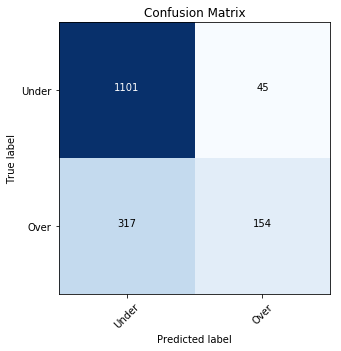

In [52]:
plt.figure(figsize=(5,5))
cnf_matrix = confusion_matrix(high_actual, high_preds)
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) #Create the basic matrix.

#Add title and Axis Labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

#Add appropriate Axis Scales
class_names = ['Under', 'Over'] #Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

#Add Labels to Each Cell
thresh = cnf_matrix.max() / 2. #Used for text coloring below
#Here we iterate through the confusion matrix and append labels to our visualization.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

plt.show()

In [53]:
print(f'This model only identifies {round(100 * cnf_matrix[1][1] / (cnf_matrix[1][0] + cnf_matrix[1][1]), 2)}% of the guitars that will sell above ${price_thresh}.')

print(f'However, when it guesses above ${price_thresh}, it\'s correct {round((cnf_matrix[1][1] / (cnf_matrix[1][1] + cnf_matrix[0][1]))*100, 2)}% of the time.')

This model only identifies 32.7% of the guitars that will sell above $510.
However, when it guesses above $510, it's correct 77.39% of the time.


****

V2:
* How much white balance a guitar's pictures need, as a feature?